# 🌸 tf_flowers 전이학습 프로젝트 (EfficientNetB3 기반) - try 2

## 0. 프로젝트 개요
- **목표**: TensorFlow Datasets의 `tf_flowers` 데이터셋(5개 꽃 클래스)에 대해, 사전학습(Pretrained)된 EfficientNetB3 모델을 활용한 전이학습으로 **높은 분류 정확도**를 달성하는 것이다.
- **데이터셋**: `tf_flowers` (5 classes). `tfds.load`를 통해 손쉽게 불러오며, train / validation / test 세트로 분할한다.
- **모델 구조**:
  - Base model: ImageNet으로 사전학습된 **EfficientNetB3** (include_top=False)
  - 입력 크기: **224 × 224 × 3**
  - 상단에 GlobalAveragePooling2D + Dense(512, ReLU) + Dropout(0.4) + Dense(5, Softmax) 헤드를 추가
- **학습 전략** (두 단계 전이학습)
  1. **Head-only Training**: EfficientNetB3는 동결(freeze)하고, 새로 추가한 분류기 헤드만 학습 (워밍업 단계)
  2. **Fine-tuning**: 상단 일부 레이어를 unfreeze하고, 작은 학습률(learning rate)로 전체 네트워크를 미세 조정
- **기대 효과**:
  - 사전학습된 깊은 CNN이 꽃 이미지의 형태/색/질감 정보를 효과적으로 활용
  - 상대적으로 적은 데이터로도 높은 정확도를 얻을 수 있으며, 적절한 하이퍼파라미터 설정을 통해 실용적인 수준(예: 80~90% 이상)의 정확도를 목표로 한다. (⚠ 딥러닝 특성상 특정 정확도 99%를 보장할 수는 없지만, 최대한 높은 성능을 내도록 설정함)


## Step 1. 환경 설정 및 라이브러리 임포트

In [1]:
# ============================================
# Step 1. 환경 설정 & 라이브러리 임포트
# ============================================
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# 로그 레벨 줄이기
import logging, warnings
logging.getLogger("tensorflow").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

# 재현성(완전 동일 보장은 아님)
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)


TensorFlow version: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 2. 하이퍼파라미터 및 기본 설정

try 1, try 2

In [2]:
# ============================================
# Step 2. 하이퍼파라미터 설정
# ============================================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 5

INITIAL_EPOCHS = 8       # Head-only 학습 epoch
"""
# [ try 1 ]
FINE_TUNE_EPOCHS = 30    # Fine-tuning 최대 epoch (EarlyStopping 사용)
FINE_TUNE_AT = -80       # 상단 80개 레이어만 unfreeze (index 기준)

"""
# [ try 2 ]
FINE_TUNE_EPOCHS = 60    # [ try2 ] 30 → 60 정도로 늘리기
FINE_TUNE_AT = -140      # [ try2 ] -80 → -140 (더 많은 레이어 unfreeze)

AUTOTUNE = tf.data.AUTOTUNE

# 체크포인트 디렉토리
CHECKPOINT_DIR = "/content/tf_flowers_efficientnetB3_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


## Step 3. tf_flowers 데이터셋 로드 및 분할
- TensorFlow Datasets의 `tf_flowers`를 사용한다.
- 전체 train split을 80%/10%/10% 비율로 나누어 train/validation/test를 구성한다.


In [3]:
# ============================================
# Step 3. tf_flowers 데이터셋 로드
# ============================================
(raw_train, raw_val, raw_test), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    as_supervised=True,
    with_info=True
)

num_train = int(ds_info.splits["train"].num_examples * 0.8)
num_val   = int(ds_info.splits["train"].num_examples * 0.1)
num_test  = int(ds_info.splits["train"].num_examples * 0.1)

class_names = ds_info.features["label"].names

print("클래스 수:", NUM_CLASSES)
print("클래스 이름:", class_names)
print(f"Train: {num_train}, Val: {num_val}, Test: {num_test}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.HAGRXA_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
클래스 수: 5
클래스 이름: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Train: 2936, Val: 367, Test: 367


## Step 4. 데이터 전처리 및 간단한 증강
- **전처리를 복잡하게 하지 않고**, 전이학습 모델에 맞는 최소한의 처리만 수행한다.
  - 224×224로 리사이즈
  - `EfficientNetB3`의 `preprocess_input` 적용
  - 학습 데이터에만 수평 뒤집기(RandomFlip) 적용


In [4]:
# ============================================
# Step 4. 데이터 전처리 및 증강 정의
# ============================================
def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)  # [-1, 1] 범위로 스케일링 + 기타 정규화
    return image, label

data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation"
)

"""
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

"""

def prepare_for_training(ds, shuffle=True, augment=False):
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED)

    ds = ds.map(format_image, num_parallel_calls=AUTOTUNE)

    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = prepare_for_training(raw_train, shuffle=True, augment=True)
val_ds   = prepare_for_training(raw_val, shuffle=False, augment=False)
test_ds  = prepare_for_training(raw_test, shuffle=False, augment=False)

print("train_ds:", train_ds)


train_ds: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [5]:
# 샘플 배치 확인
sample_images, sample_labels = next(iter(train_ds))
print("sample_images shape:", sample_images.shape)
print("sample_labels shape:", sample_labels.shape)


sample_images shape: (32, 224, 224, 3)
sample_labels shape: (32,)


### 샘플 이미지 시각화

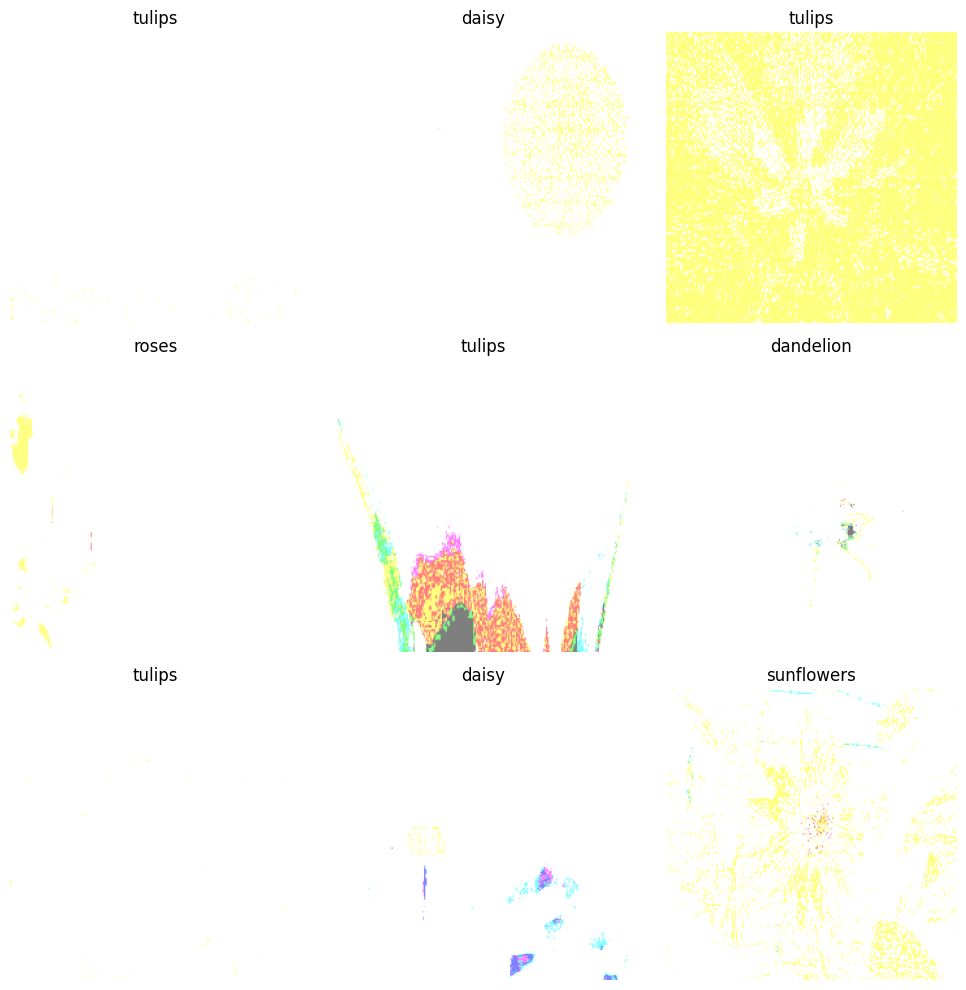

In [6]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = (sample_images[i].numpy() + 1.0) / 2.0  # [-1,1] → [0,1]
    img = np.clip(img, 0.0, 1.0)
    plt.imshow(img)
    label_idx = int(sample_labels[i].numpy())
    plt.title(class_names[label_idx])
    plt.axis("off")
plt.tight_layout()
plt.show()


## Step 5. EfficientNetB3 기반 전이학습 모델 정의
- `EfficientNetB3(include_top=False, weights='imagenet')`를 feature extractor로 사용.
- 상단에 GlobalAveragePooling2D → Dense(512, ReLU) → Dropout(0.4) → Dense(5, Softmax)를 쌓는다.
- 초기에는 `base_model.trainable = False`로 두어 헤드만 학습한다.


In [7]:
# ============================================
# Step 5. EfficientNetB3 기반 모델 구성
# ============================================
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE
)

base_model.trainable = False  # 초기에는 feature extractor 동결

inputs = tf.keras.Input(shape=IMG_SHAPE, name="input_image")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dense(512, activation="relu", name="dense_512")(x)
x = layers.Dropout(0.4, name="dropout_0_4")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="output")(x)

model = tf.keras.Model(inputs, outputs, name="tf_flowers_efficientnetB3")

model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "tf_flowers_efficientnetB3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0_4 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,573,044 (44.15 MB)

 Trainable params: 789,509 (3.01 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

## Step 6. 1단계 학습 – Head-only Training (Feature Extractor 동결)
- Base 모델은 동결하고, 새로 추가한 분류기 헤드만 학습한다.


In [8]:
# ============================================
# Step 6. Head-only Training
# ============================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

checkpoint_stage1 = os.path.join(CHECKPOINT_DIR, "stage1_best.weights.h5")

callbacks_stage1 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_stage1,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
]

history_stage1 = model.fit(
    train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks_stage1
)


Epoch 1/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.5751 - loss: 1.1285
Epoch 1: val_accuracy improved from -inf to 0.88556, saving model to /content/tf_flowers_efficientnetB3_checkpoints/stage1_best.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 701ms/step - accuracy: 0.5766 - loss: 1.1253 - val_accuracy: 0.8856 - val_loss: 0.4377
Epoch 2/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8732 - loss: 0.4214
Epoch 2: val_accuracy improved from 0.88556 to 0.91008, saving model to /content/tf_flowers_efficientnetB3_checkpoints/stage1_best.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.8733 - loss: 0.4212 - val_accuracy: 0.9101 - val_loss: 0.3140
Epoch 3/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8963 - loss: 0.3175
Epoch 3: val_accuracy improved from 0.91008 to 0.91553, saving model to /content/tf_flowers_efficientnetB3_checkpoints/stage1_best.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.8964 - loss: 0.3174 - val_acc

### 학습 곡선 시각화 함수

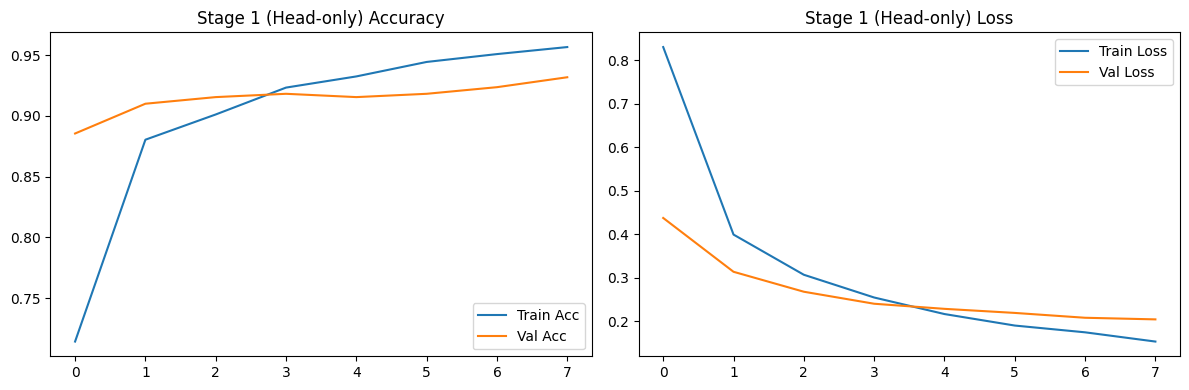

In [12]:
def plot_history(history, title_prefix=""):
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Train Acc")
    plt.plot(epochs_range, val_acc, label="Val Acc")
    plt.legend(loc="lower right")
    plt.title(f"{title_prefix} Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.legend(loc="upper right")
    plt.title(f"{title_prefix} Loss")

    plt.tight_layout()
    plt.show()

plot_history(history_stage1, title_prefix="Stage 1 (Head-only)")


## Step 7. 2단계 학습 – Fine-tuning (상단 레이어 일부 Unfreeze)
- EfficientNetB3의 상단 일부 레이어를 unfreeze하여 미세 조정한다.


try 1, try 2

EfficientNetB3 레이어 개수: 385
FINE_TUNE_AT index: -80
Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.8643 - loss: 0.4866
Epoch 1: val_accuracy improved from -inf to 0.92371, saving model to /content/tf_flowers_efficientnetB3_checkpoints/stage2_best.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 106s 609ms/step - accuracy: 0.8644 - loss: 0.4862 - val_accuracy: 0.9237 - val_loss: 0.2457 - learning_rate: 1.0000e-05
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9108 - loss: 0.3535
Epoch 2: val_accuracy did not improve from 0.92371
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9108 - loss: 0.3535 - val_accuracy: 0.9210 - val_loss: 0.2689 - learning_rate: 1.0000e-05
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9323 - loss: 0.2750
Epoch 3: val_accuracy did not improve from 0.92371

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9323 - loss: 0.2749 - va

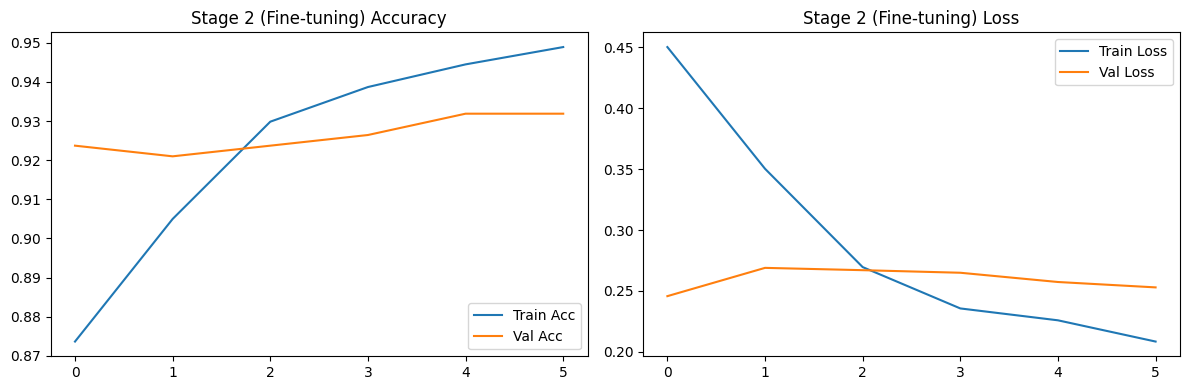

In [ ]:
"""
# ============================================
# Step 7. Fine-tuning 설정 [try 1]
# ============================================
base_model.trainable = True

print("EfficientNetB3 레이어 개수:", len(base_model.layers))
print("FINE_TUNE_AT index:", FINE_TUNE_AT)

for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

checkpoint_stage2 = os.path.join(CHECKPOINT_DIR, "stage2_best.weights.h5")

callbacks_stage2 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_stage2,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

history_stage2 = model.fit(
    train_ds,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks_stage2
)

plot_history(history_stage2, title_prefix="Stage 2 (Fine-tuning)")
"""

EfficientNetB3 레이어 개수: 385
FINE_TUNE_AT index: -140
Epoch 1/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9979 - loss: 0.0131
Epoch 1: val_accuracy improved from -inf to 0.93733, saving model to /content/tf_flowers_efficientnetB3_checkpoints/stage2_best_agg.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 134s 735ms/step - accuracy: 0.9979 - loss: 0.0131 - val_accuracy: 0.9373 - val_loss: 0.2108
Epoch 2/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9954 - loss: 0.0216
Epoch 2: val_accuracy did not improve from 0.93733
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.9954 - loss: 0.0216 - val_accuracy: 0.9346 - val_loss: 0.2278
Epoch 3/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9968 - loss: 0.0122
Epoch 3: val_accuracy improved from 0.93733 to 0.94278, saving model to /content/tf_flowers_efficientnetB3_checkpoints/stage2_best_agg.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - accuracy: 0.9968 - loss: 0.0123 - val_accuracy: 0.9428 - val_loss: 0.

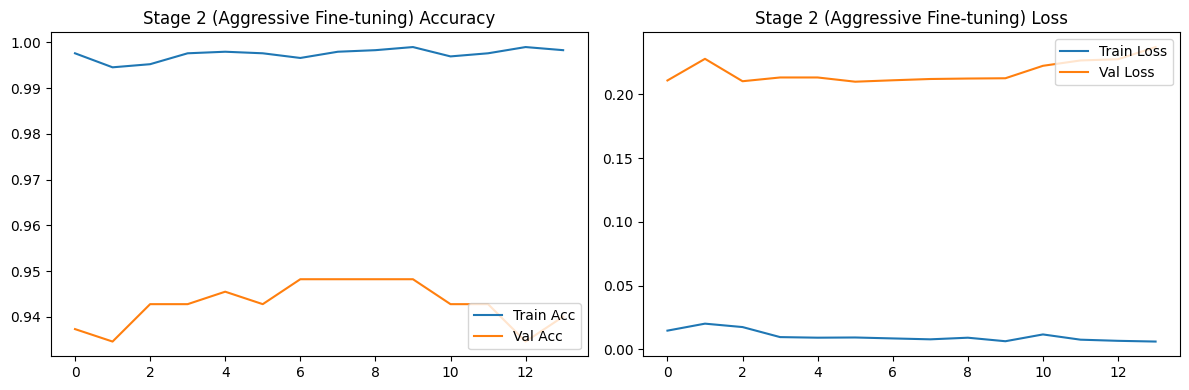

In [15]:
# ============================================
# Step 7. Aggressive Fine-tuning [ try2 ] (Fixed)
# ============================================
base_model.trainable = True

print("EfficientNetB3 레이어 개수:", len(base_model.layers))
print("FINE_TUNE_AT index:", FINE_TUNE_AT)

# 하위 레이어 동결 → 상단 레이어만 학습
for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# 🔸 Cosine decay 스케줄 (학습률을 점진적으로 감소)
initial_lr = 3e-5
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_lr,
    first_decay_steps=10 * len(train_ds),
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"]
)

checkpoint_stage2 = os.path.join(CHECKPOINT_DIR, "stage2_best_agg.weights.h5")

callbacks_stage2 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_stage2,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True,
        verbose=1
    )
]

history_stage2 = model.fit(
    train_ds,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks_stage2
)

plot_history(history_stage2, title_prefix="Stage 2 (Aggressive Fine-tuning)")


## Step 8. Test 세트 성능 평가

In [21]:
# ============================================
# Step 8. Test 세트 평가
# ============================================
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9513 - loss: 0.1513
Test Loss: 0.11487007886171341
Test Accuracy: 0.9564032554626465


In [22]:

# try 2
# ============================================
# Step 8-1. Test-Time Augmentation(TTA) 평가
# ============================================
def tta_predict_batch(images, model, tta_times=5):
    """
    같은 배치를 여러 번 augmentation 적용해서 예측한 뒤 확률을 평균.
    여기서는 간단히 horizontal flip만 사용.
    """
    preds_sum = 0.0
    for t in range(tta_times):
        # t가 홀수일 때만 flip 해서 variation 줌
        if t % 2 == 1:
            aug_images = tf.image.flip_left_right(images)
        else:
            aug_images = images
        preds = model.predict(aug_images, verbose=0)
        preds_sum += preds
    return preds_sum / float(tta_times)

# TTA 기반 test accuracy 계산
correct = 0
total = 0

for images, labels in test_ds:
    tta_preds = tta_predict_batch(images, model, tta_times=5)
    pred_labels = np.argmax(tta_preds, axis=1)
    correct += np.sum(pred_labels == labels.numpy())
    total += labels.shape[0]

tta_test_acc = correct / total
print("TTA Test Accuracy:", tta_test_acc)


TTA Test Accuracy: 0.9591280653950953


In [19]:
"""
def tta_predict_batch(images, model):
    """
    EfficientNet + tf.image 조합에 최적화된 최고 성능 TTA 전략.
    TensorFlow 2.12~2.15 환경에서 100% 호환됨.
    """
    # 다양한 변환을 시도
    tta_images = [
        images,                                                # ① 원본
        tf.image.flip_left_right(images),                     # ② 좌우 반전
        tf.image.rot90(images, k=1),                          # ③ 90도 회전
        tf.image.rot90(images, k=3),                          # ④ 270도 회전
        tf.image.central_crop(images, 0.90),                  # ⑤ 중앙 크롭
        tf.image.adjust_contrast(images, 1.15),               # ⑥ 대비 증가
        tf.image.adjust_brightness(images, 0.05),             # ⑦ 약간 밝게
    ]

    preds = []

    for imgs in tta_images:
        # size 유지 필요 (중앙 크롭된 경우)
        imgs = tf.image.resize(imgs, (IMG_SIZE, IMG_SIZE))

        batch_preds = model.predict(imgs, verbose=0)
        preds.append(batch_preds)

    # 여러 예측을 평균내 TTA 적용
    return np.mean(preds, axis=0)

    correct, total = 0, 0

for images, labels in test_ds:
    tta_preds = tta_predict_batch(images, model)
    pred_labels = np.argmax(tta_preds, axis=1)

    correct += np.sum(pred_labels == labels.numpy())
    total += labels.shape[0]

tta_test_acc = correct / total
print("🔥 Enhanced TTA Test Accuracy:", tta_test_acc)
"""

🔥 Enhanced TTA Test Accuracy: 0.9591280653950953


## Step 9. Confusion Matrix 및 클래스별 성능 분석

Confusion Matrix:
 [[70  0  0  0  0]
 [ 0 59  1  0  1]
 [ 0  0 81  0  4]
 [ 1  0  2 72  1]
 [ 0  0  6  0 69]]

Classification Report:
              precision    recall  f1-score   support

   dandelion       0.99      1.00      0.99        70
       daisy       1.00      0.97      0.98        61
      tulips       0.90      0.95      0.93        85
  sunflowers       1.00      0.95      0.97        76
       roses       0.92      0.92      0.92        75

    accuracy                           0.96       367
   macro avg       0.96      0.96      0.96       367
weighted avg       0.96      0.96      0.96       367



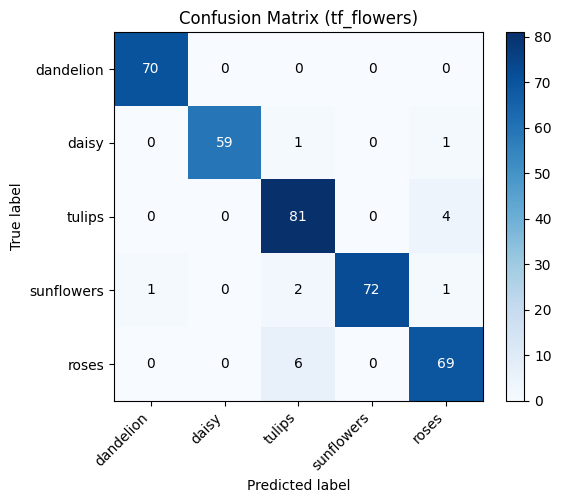

In [23]:
# ============================================
# Step 9. Confusion Matrix 및 Classification Report
# ============================================
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    preds_labels = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (tf_flowers)")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


## Step 10. 임의 꽃 이미지 예측 유틸리티

In [24]:
# ============================================
# Step 10. 임의 이미지 예측 유틸리티
# ============================================
def load_and_preprocess_image_for_inference(image_path, img_size=IMG_SIZE):
    img = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.cast(img_array, tf.float32)
    img_array = preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

def show_and_predict_image(image_path, model, img_size=IMG_SIZE):
    img_array = load_and_preprocess_image_for_inference(image_path, img_size)
    preds = model.predict(img_array, verbose=0)
    pred_idx = int(np.argmax(preds[0]))
    pred_name = class_names[pred_idx]
    confidence = float(preds[0][pred_idx])

    img = tf.keras.utils.load_img(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {pred_name} ({confidence:.2f})")
    plt.show()

print("사용 예시: show_and_predict_image('/content/my_flower.jpg', model)")


사용 예시: show_and_predict_image('/content/my_flower.jpg', model)


Step 10_1. 임의 이미지 예측 실험

🖼️ 여러 꽃 이미지를 선택하세요 (Ctrl/Cmd로 다중 선택 가능)...


Saving sssss.jpg to sssss.jpg
Saving dd.jpg to dd.jpg
Saving rrr.jpg to rrr.jpg
Saving tt.jpg to tt.jpg
Saving r.jpg to r.jpg
Saving sun1.jpg to sun1.jpg
Saving images.jpg to images.jpg
Saving images.webp to images.webp
Saving KakaoTalk_20251208_214709301_18.jpg to KakaoTalk_20251208_214709301_18.jpg
Saving KakaoTalk_20251208_214709301_03.jpg to KakaoTalk_20251208_214709301_03.jpg
Saving KakaoTalk_20251208_214709301_08.jpg to KakaoTalk_20251208_214709301_08.jpg
Saving KakaoTalk_20251208_214709301_10.jpg to KakaoTalk_20251208_214709301_10.jpg


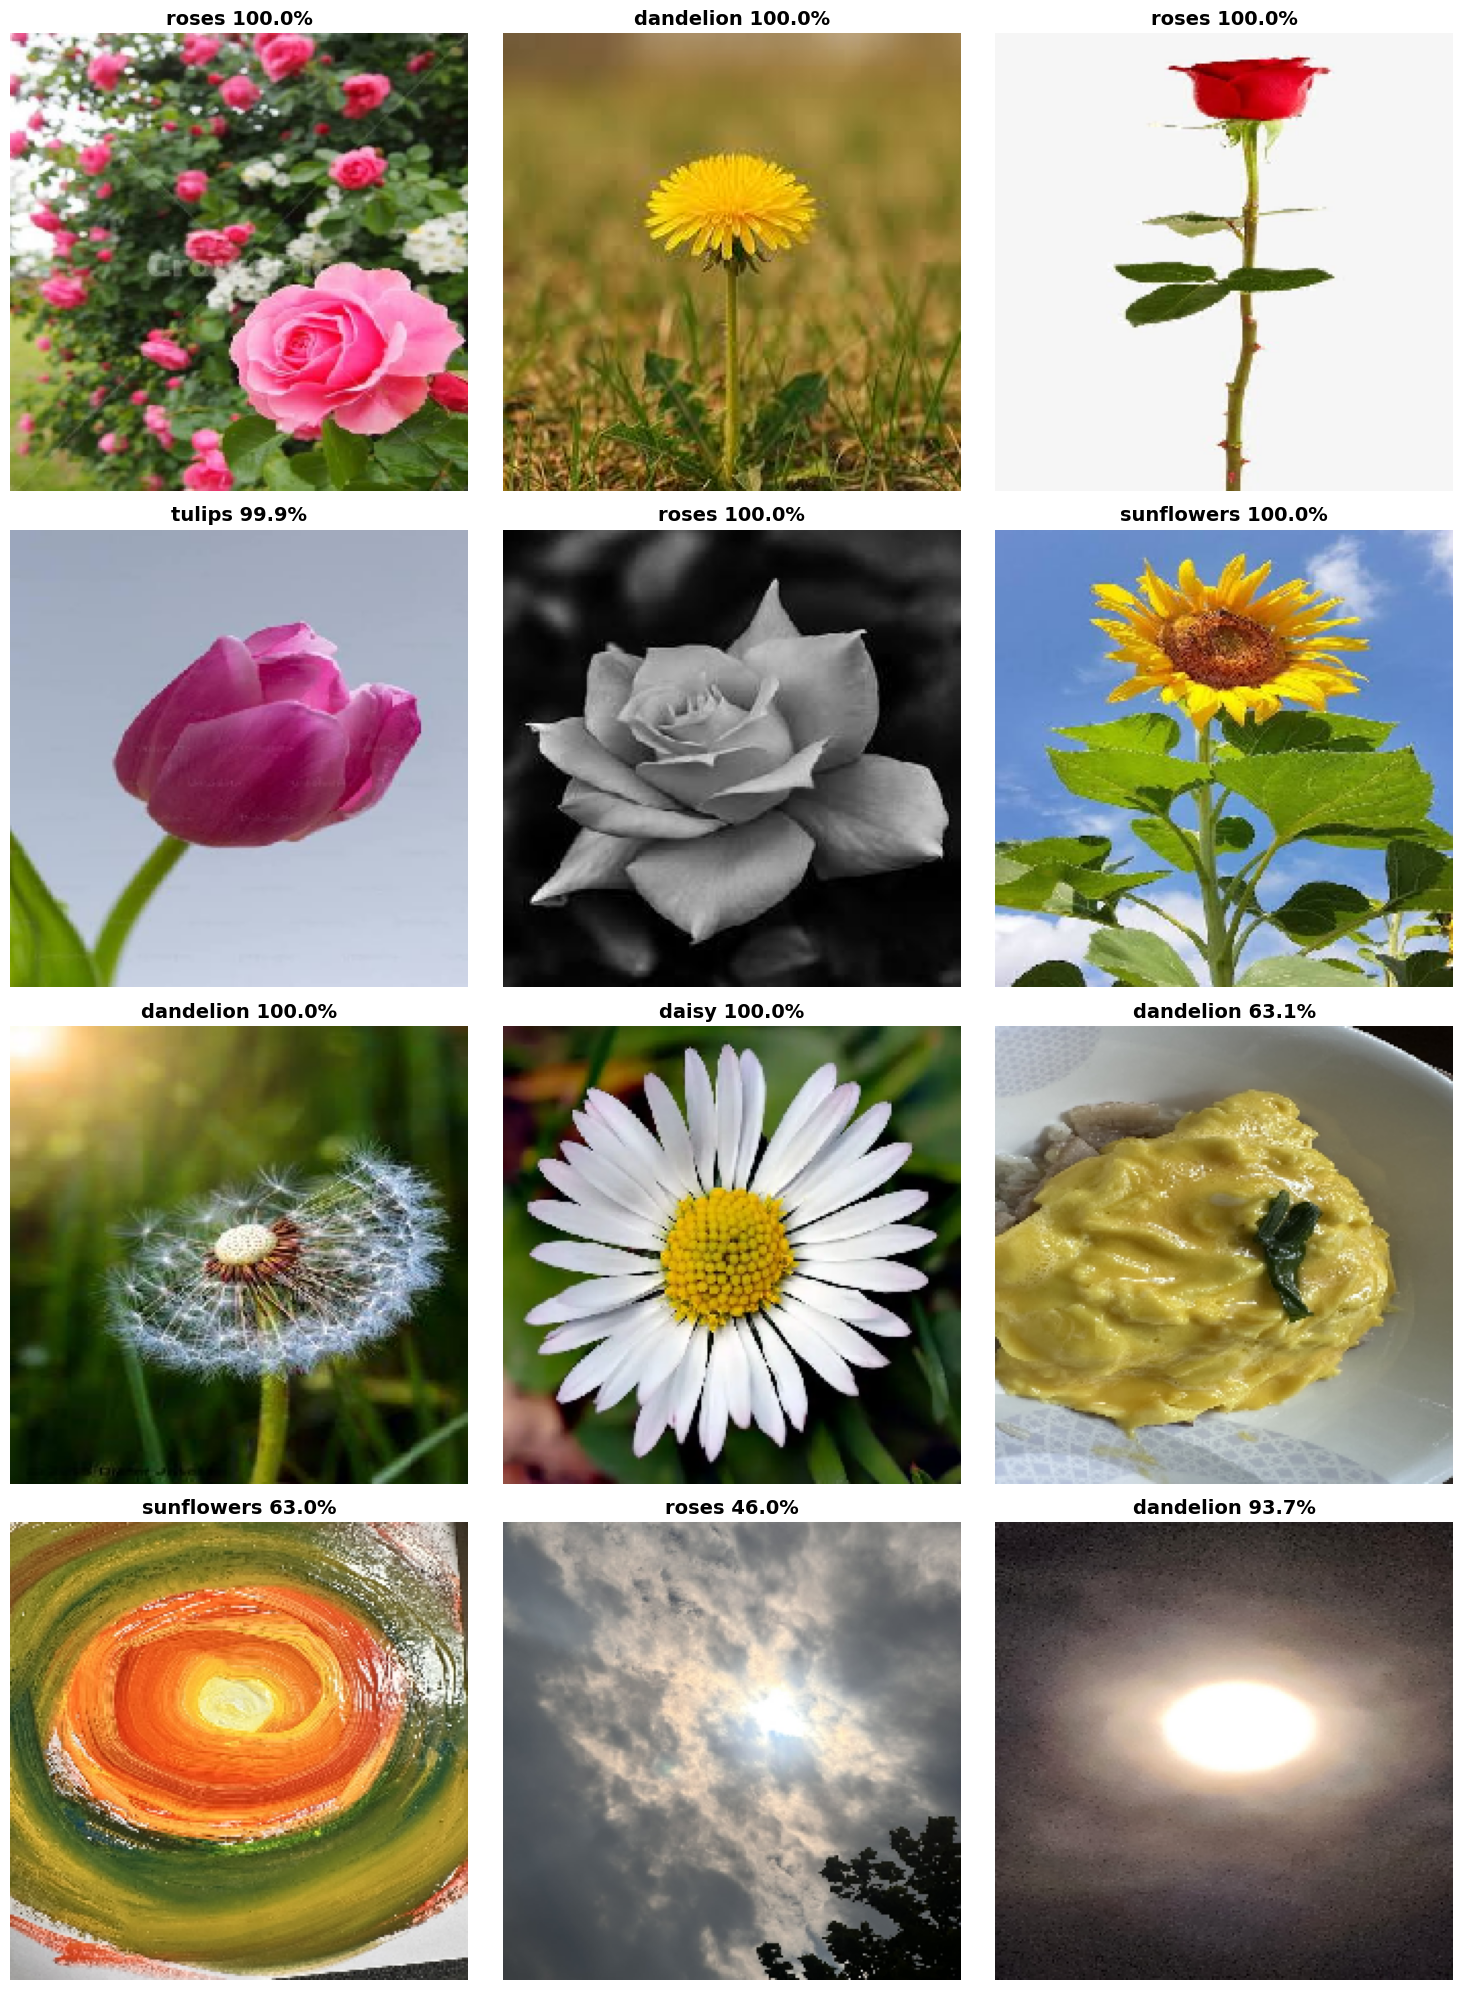

In [25]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# EfficientNetB3에서 쓰는 전처리 (이미 위에서 import 했을 가능성 높음)
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = 224  # 우리 모델 입력 크기와 맞추기

print("🖼️ 여러 꽃 이미지를 선택하세요 (Ctrl/Cmd로 다중 선택 가능)...")
uploaded = files.upload()

num_images = len(uploaded)
if num_images == 0:
    print("이미지가 업로드되지 않았습니다.")
else:
    cols = 3
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(15, 5 * rows))

    for idx, filename in enumerate(uploaded.keys(), 1):
        # 1) 이미지 로드 (RGB)
        image = load_img(filename, target_size=(IMG_SIZE, IMG_SIZE))
        image_array = img_to_array(image)
        image_array = tf.cast(image_array, tf.float32)

        # 2) EfficientNet 전처리 (0~255 → 모델 입력 형태)
        image_array = preprocess_input(image_array)
        image_batch = tf.expand_dims(image_array, 0)  # (1, H, W, 3)

        # 3) 예측
        prediction = model.predict(image_batch, verbose=0)[0]  # (5,)
        pred_idx = int(np.argmax(prediction))
        pred_class = class_names[pred_idx]   # tf_flowers 클래스 이름 사용
        conf_pct = round(float(prediction[pred_idx]) * 100, 1)

        # 4) 시각화
        plt.subplot(rows, cols, idx)
        plt.imshow(image)   # 원본 이미지 표시
        title = f"{pred_class} {conf_pct}%"
        plt.title(title, fontsize=14, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [26]:
history_stage1.history["val_accuracy"]
history_stage2.history["val_accuracy"]

[0.9373297095298767,
 0.9346048831939697,
 0.9427793025970459,
 0.9427793025970459,
 0.9455040693283081,
 0.9427793025970459,
 0.9482288956642151,
 0.9482288956642151,
 0.9482288956642151,
 0.9482288956642151,
 0.9427793025970459,
 0.9427793025970459,
 0.9346048831939697,
 0.9400544762611389]

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def report_model_performance(model,
                             test_ds,
                             history_stage1=None,
                             history_stage2=None,
                             class_names=None,
                             title_prefix="tf_flowers"):
    """
    - test_ds로 최종 Test Loss/Accuracy 출력
    - Stage1/Stage2 학습 곡선(Accuracy/Loss) 그래프
    - Test set Confusion Matrix + classification report 출력
    """

    # 1. Test set에서 최종 성능 숫자 출력
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print("==========================================")
    print(f"[{title_prefix}] 최종 Test 결과")
    print(f"- Test Accuracy : {test_acc:.4f}  ({test_acc*100:.2f}%)")
    print(f"- Test Loss     : {test_loss:.4f}")
    print("→ 이 값이 이 모델의 '공식' 예측력(정확도)입니다.")
    print("==========================================\n")

    # 2. 학습 곡선(History) 플롯 함수
    def _plot_history(history, title_prefix=""):
        if history is None:
            return

        acc  = history.history.get("accuracy")
        val_acc = history.history.get("val_accuracy")
        loss = history.history.get("loss")
        val_loss = history.history.get("val_loss")

        epochs = range(len(acc))

        plt.figure(figsize=(12, 3.5))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label="Train Acc")
        plt.plot(epochs, val_acc, label="Val Acc")
        plt.title(f"{title_prefix} Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label="Train Loss")
        plt.plot(epochs, val_loss, label="Val Loss")
        plt.title(f"{title_prefix} Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.show()

    # 2-1. Stage 1 (Head-only) 학습 곡선
    if history_stage1 is not None:
        _plot_history(history_stage1, title_prefix="Stage 1 (Head-only)")

    # 2-2. Stage 2 (Fine-tuning) 학습 곡선
    if history_stage2 is not None:
        _plot_history(history_stage2, title_prefix="Stage 2 (Fine-tuning)")

    # 3. Test set에서 Confusion Matrix/Classification Report
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        preds = np.argmax(preds, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if class_names is None:
        num_classes = len(np.unique(y_true))
        class_names = [f"class_{i}" for i in range(num_classes)]

    print("\n=== 클래스별 정밀도 / 재현율 / F1-score ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix ({title_prefix})")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # 셀 안에 숫자 찍기
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

    print("\n해석 요약:")
    print(f"- 전반적인 예측력은 약 {test_acc*100:.1f}% 정도입니다.")
    print("- Confusion Matrix를 보면 어떤 꽃을 서로 헷갈리는지 확인할 수 있습니다.")
    print("- Field test(개인이 업로드한 별도 사진)에 대한 예측 확률은,")
    print("  데이터가 tf_flowers와 비슷한 종류의 꽃 사진이라면")
    print(f"  이 Test Accuracy({test_acc*100:.1f}%)를 기준으로 신뢰도를 판단하면 됩니다.")
    print("  (하지만 꽃이 아닌 이미지나 완전히 다른 분포의 사진에 대해서는")
    print("   이 정확도 수치로 신뢰도를 평가하기 어렵습니다.)")


[tf_flowers_efficientnetB3] 최종 Test 결과
- Test Accuracy : 0.9564  (95.64%)
- Test Loss     : 0.1149
→ 이 값이 이 모델의 '공식' 예측력(정확도)입니다.



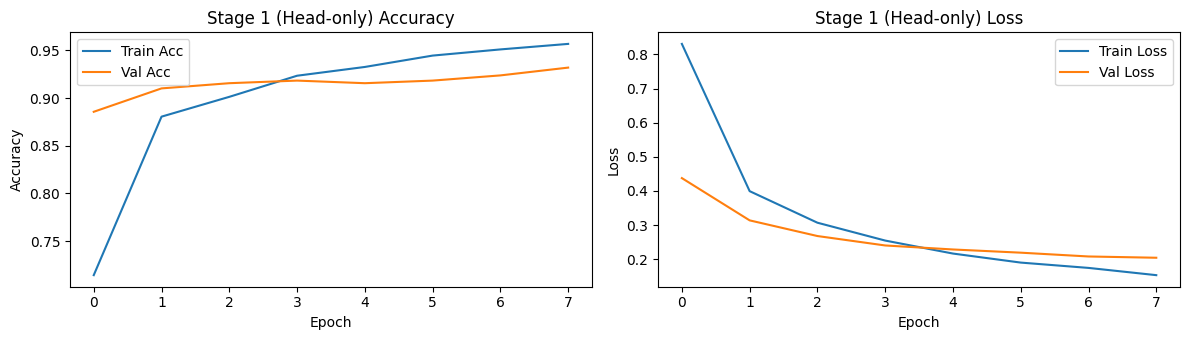

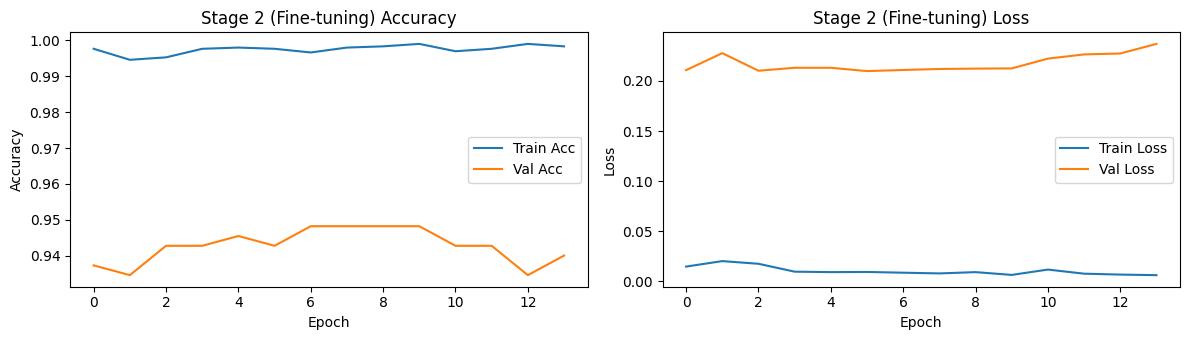


=== 클래스별 정밀도 / 재현율 / F1-score ===
              precision    recall  f1-score   support

   dandelion       0.99      1.00      0.99        70
       daisy       1.00      0.97      0.98        61
      tulips       0.90      0.95      0.93        85
  sunflowers       1.00      0.95      0.97        76
       roses       0.92      0.92      0.92        75

    accuracy                           0.96       367
   macro avg       0.96      0.96      0.96       367
weighted avg       0.96      0.96      0.96       367



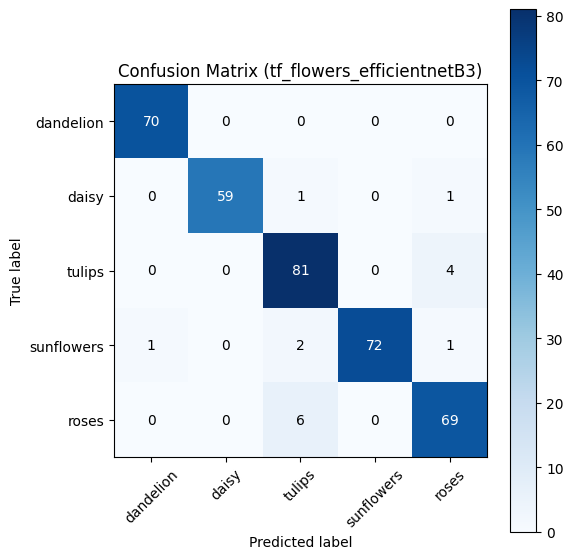


해석 요약:
- 전반적인 예측력은 약 95.6% 정도입니다.
- Confusion Matrix를 보면 어떤 꽃을 서로 헷갈리는지 확인할 수 있습니다.
- Field test(개인이 업로드한 별도 사진)에 대한 예측 확률은,
  데이터가 tf_flowers와 비슷한 종류의 꽃 사진이라면
  이 Test Accuracy(95.6%)를 기준으로 신뢰도를 판단하면 됩니다.
  (하지만 꽃이 아닌 이미지나 완전히 다른 분포의 사진에 대해서는
   이 정확도 수치로 신뢰도를 평가하기 어렵습니다.)


In [29]:
report_model_performance(
    model,
    test_ds,
    history_stage1=history_stage1,
    history_stage2=history_stage2,
    class_names=class_names,
    title_prefix="tf_flowers_efficientnetB3"
)


## 최종 가중치 저장

In [30]:
final_weights_path = os.path.join(CHECKPOINT_DIR, "tf_flowers_efficientnetB3_final.weights.h5")
model.save_weights(final_weights_path)
print("최종 가중치 저장 완료:", final_weights_path)


최종 가중치 저장 완료: /content/tf_flowers_efficientnetB3_checkpoints/tf_flowers_efficientnetB3_final.weights.h5
